1. 
First need to read in the weekly returns for the 9 specified stocks from the period Jan 2005 - Dec 2009.
Stocks are Wells Fargo, JP Morgan, Apple, Microsoft, Google, IBM, Walmart, AIG, and GE.

In [195]:
#Need to run this command at anaconda prompt: "$ pip3 install yfinance"
import arch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf


In [196]:
#spx is the sp500
data = yf.download(
        tickers = 'wfc jpm aapl msft googl ibm wmt aig ge spy', 
        start = "2005-01-01", 
        end = "2008-12-31",
        interval = "1wk",
        group_by = 'ticker',
        threads = True)

[*********************100%***********************]  10 of 10 completed


Now lets turn this multi-index df into a regular df and looking only at AdjClose which we'll use to calculate 
the logreturn values weekly. Also, periodic NA values result from yfinance throwing in random non week ending datapoints, probably resulting from choosing Jan 1st 2005 as the starting point which was a Saturday. So, lets drop those and then calculate log returns. $$ \textbf{Beware, running this cell twice kills the structure, so if you do, you need to run the yf.download cell again before moving on.} $$

In [197]:
AdjClose = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close']
processed = AdjClose.dropna()
processed.columns = processed.columns.droplevel(1)  #turns columns from multi-index to normal index
logRet = np.log(processed)
logRet = logRet.diff()
logRet = logRet.dropna()
logRet.head()

,MSFT,JPM,SPY,AAPL,IBM,GE,WFC,WMT,GOOGL,AIG
Date,,,,,,,,,,
2005-01-08,-0.020838,-0.006762,-0.001690,0.013625,-0.017696,-0.013422,-0.024093,0.000000,0.031083,-0.021539
2005-01-15,-0.018157,-0.025718,-0.012424,0.004122,-0.018448,-0.011041,-0.009436,-0.018319,-0.060237,-0.000302
2005-01-22,0.020452,0.004062,0.005550,0.048324,0.005505,0.017495,0.006631,-0.011001,0.010882,-0.003940
2005-01-29,0.005333,0.018477,0.023564,0.063626,0.017290,0.013889,0.007572,0.019454,0.071071,0.024893
2005-02-05,-0.013387,-0.005588,0.004482,0.029618,-0.012885,-0.000552,-0.003416,-0.025769,-0.086638,0.079678


2. 
Conduct the NPEB analysis on the individual returns in order to generate the return distribution as well as the covariance relationships.



and via the text, we know that $\mu_{n}$ and $\textbf{V}_{n}$ are 

$$ \mu_{n} = (\hat{\beta}_{1}^{T} x_{1,n-1}, ... , \hat{\beta}_{m}^{T} x_{m,n-1} )^{T} $$

$$ \textbf{V}_{n} = \textbf{\mu}_{n} \textbf{\mu}_{n}^{T} + (\hat{s}_{i,n} \hat{s}_{j,n} \hat{\sigma}_{i,j}) $$

Then, search for $\eta$ by minimizing (2.11) for given $\lambda$, followed by searching for $\lambda$ over a grid to maximizing the information ratio: 
$$E_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b}) / \sqrt{(Var_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b})} $$



In [272]:
## Lets first find the prior distribution via MLE estimators (practice of NPEB). 
#First, we can model the return at time t as Linear Regression with Garch errors


X = logRet.shift(1) #we'll be using prevoius observations
risk_lambda = [2**i for i in range(-3,4)]
numAssets = 9
onePerReturn = []
windowSize = 120

s_prev = np.zeros((len(logRet), numAssets))


for time, i in enumerate(range(100, 121)): #len(logRet))):
    mu_n = np.zeros(numAssets)
    V_n = np.ones((numAssets, numAssets))
    z_t = np.ones(numAssets)
    
    iterator = 0

    for col in logRet.columns:
        if col == 'SPY':
            continue
        leftIndex = max(0, i - windowSize)
        col_1 = X.columns.get_loc('SPY')
        col_2 = X.columns.get_loc(col)
        exog = X.iloc[1:i, [col_1, col_2]]
        y = logRet.iloc[1:i, logRet.columns == col].to_numpy().flatten()
        

        model = arch.arch_model(y, x = exog, mean = 'ARX', dist = 't', rescale = True)
        res = model.fit(disp = 'off')
        print(res.scale)
        
        
        data = np.array([1,X.iloc[i, col_1], X.iloc[i, col_2]])

        
        #parmams list as follows: also need to undo rescale for parameters
        scale = res.scale
        Beta_constant = res.params[0]  
        Beta_SPY = res.params[1]        
        Beta_prevReturn = res.params[2]      
        s_omega = res.params[3] 
        s_alpha = res.params[4]  
        s_beta = res.params[5]   
        s_nu = res.params[6]

        
        mu_n[iterator] = np.transpose(np.array([Beta_constant, Beta_SPY, Beta_prevReturn]))@data 
        
        s_i = np.sqrt(s_omega + s_alpha*(s_prev[time-1,iterator]**2) + \
                      s_beta*(logRet.iloc[time-1, logRet.columns == col]**2))
        
        s_prev[time, iterator] = s_i
        

        #To get cov(zi, zj), need to divide epsilon by s
        epsilon = logRet.iloc[i, logRet.columns == col] - mu_n[iterator]
        z_t[iterator] = epsilon 
        
        iterator += 1
        
    #Finish calculating V_n, mult by sigma's


    for i in range(0, numAssets):
        for j in range(0, numAssets):
            V_n[i,j] = (z_t[i]*z_t[j])*s_prev[time, i]*s_prev[time, j] + mu[i]*mu[j]
    
    
    optimalWeights = calcOptPortfolioWeight(mu_n, V_n, risk_lambda, i, logRet)
    onePerReturn.append(np.transpose(optimalWeights)@logRet.iloc[i, logRet.columns != 'SPY'])
    print(optimalWeights)
    print(onePerReturn[time])
    print(time)
    
        


1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
eta: -0.09793848757603531
Info Ratio: -0.4518415989929577
eta: -0.10307198105737173
Info Ratio: -0.4497922474417985
eta: -0.11333896802004455
Info Ratio: -0.4492417333609802
eta: -0.13387294194539023
Info Ratio: -0.4392493180405277
eta: -0.17494088979608155
Info Ratio: -0.39155587347859216
eta: -0.2570767854974642
Info Ratio: -0.34811006846184833
[ 0.48843671  5.52645578 -7.88635186  0.01775294  7.89417485  0.20399391
 -1.16252237 -3.419467   -0.66247295]
0.39060968041276
0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
eta: -0.15618650266762207
Info Ratio: -0.5974175518634632
eta: -0.1527973218073394
Info Ratio: -0.6479685450521235
eta: -0.14601896008677404
Info Ratio: -0.5997044828505296
eta: -0.13246223664564333
Info Ratio: -0.5729585862587215
eta: -0.10534878976338193
Info Ratio: -0.5739576466812337
eta: -0.05112189599885912
Info Ratio: -0.5707537434809584
[ 1.25666156  1.66491643 -9.33385685  2.1209601   2.4454453   2.46926127
  2.11056857 -3.1800509   1.4

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
eta: -0.05058671711150871
Info Ratio: -0.13601264506417604
eta: -0.054204279998401175
Info Ratio: -0.14417972377993854
eta: -0.06143940577218611
Info Ratio: -0.1533967552459458
eta: -0.07590965731975598
Info Ratio: -0.13693285944620134
eta: -0.10485016041489571
Info Ratio: -0.10618544024235325
eta: -0.16273116660517517
Info Ratio: -0.13458438488011348
[  0.69262634   7.40445846  -7.59764373  -6.68962903   9.33794946
   9.78779167  -8.48676273 -11.72055086   8.27176042]
0.7828235763405504
16
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
eta: -0.14912177909283036
Info Ratio: -0.807023701299614
eta: -0.14376485920040427
Info Ratio: -0.8052510094996503
eta: -0.13305101941555209
Info Ratio: -0.7582690142920667
eta: -0.11162333984584769
Info Ratio: -0.794541974346135
eta: -0.06876798070643886
Info Ratio: -0.7666548475478918
eta: 0.016942737572378748
Info Ratio: -0.8179507811123757
[  2.29519378   2.78874146 -11.64532253   0.91925652   2.5720896
   2.15376033   0.4916848

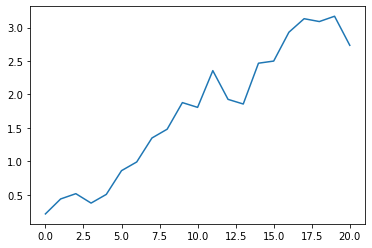

In [271]:
#Define function for calculating mu and V
onePerReturn
cum = np.cumsum(onePerReturn)
plt.plot(cum)

In [269]:
#Define function for calculating optimal weight portfolio and eta for given lambda
def calcOptPortfolioWeight(mu_n, V_n, risk_lambda, i, logRet):
    informationRatio = -1000000 #essentially like -inf
    optWeight = np.ones(mu_n.shape)
    inverseV_n = np.linalg.pinv(V_n)
    
    
    for lam in risk_lambda:
        ones = np.ones(mu_n.shape[0])
    
        A_n = np.transpose(mu_n)@inverseV_n@ones
        B_n = np.transpose(mu_n)@inverseV_n@mu_n
        C_n = np.transpose(ones)@inverseV_n@ones
        
    
        #assert (B_n - (A_n**2)/C_n)*(B_n - ((A_n**2)/C_n) - 1) < 0
        #print("C(eta) has no minimum")
    
        Z2 = (B_n - ((A_n**2)/C_n))*(B_n - ((A_n**2)/C_n) - 1)
        Z1 = ((1/(2.0*lam)) + (A_n/C_n))*(B_n - ((A_n**2)/C_n))
        eta = -(Z1*2*lam)/Z2
        print("eta: " + str(eta))
        
        term1 = (1.0/C_n)*inverseV_n@ones 
        term2 = (eta/(2*lam))*inverseV_n@(mu_n - (A_n/C_n)*ones)
        weight = term1 + term2
        newInfoRatio = infoRatio(weight, i, logRet)
        if newInfoRatio > informationRatio:
            print("Info Ratio: " + str(newInfoRatio))
            optWeight = weight
        
    return optWeight
        
def infoRatio(weight, i, logRet):
    
    #E[w^T * mu]
    #E[w^T * SIGMA * w]
    #Var[w^T * mu]
    
    B = 50
    left_index = max(0, i-120)
    numObs = logRet.iloc[left_index:i].shape[0]
    e1 = np.zeros(B)
    e2 = np.zeros(B)
    e3 = np.zeros(B)
    for j in range(1,B):
        mu, V = sampleStat(logRet.iloc[left_index:i,logRet.columns != 'SPY' ].sample(n= numObs, replace=True))
        e1[j] = np.transpose(weight)@mu
        e2[j] = np.transpose(weight)@V@weight
        e3[j] = (e1[j])**2

        
    Variance = np.sqrt(np.mean(e2) + (np.mean(e3) - np.mean(e1)**2))
    infoRatio = (np.mean(e1) - logRet.iloc[i, logRet.columns == 'SPY']) /Variance
    
    return infoRatio.values[0]
        
        
def sampleStat(data):
    mu = data.mean(axis = 0)
    V = data.cov()
    return (mu, V)

5. 
Using these dynamic portfolio weights, model the cumulative returns for the period and compare them to plug-in portfolio.

In [12]:
#Lets first find the plug-in returns using the same idea with a sliding window

def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
    one = np.ones((len(retMean),1))
    
    A = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@one)
    B = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@riskAdjMean)
    C = np.transpose(one)@inverseCov@one
    D = B*C - A**2

    numerator = B*inverseCov@one - A*inverseCov@riskAdjMean
    numerator += targetReturn*(C*inverseCov@riskAdjMean - A*inverseCov@one)
    optimalWeights = numerator * (1/D)

    return optimalWeights

In [50]:
windowSize = 120
rf = 0
numAssets = 9 
maxRet = 0.01   #This is very conservative, is there some way to enforce no short-selling?

#In order to find the plug-in portfolio that returns the highest information ratio, we'll need to do some
#grid searching

mu = np.linspace(0.1, maxRet, 51)

plugInReturn = []
riskFree = np.full((numAssets,1), rf)


for i in range(10, len(logRet)):   #algo unstable for low history, so we start at n = 10
    leftIndex = max(0, i - windowSize)
    sampleMean = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].mean(axis = 0)
    sampleCov = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].cov()
    periodRet = logRet.iloc[i, logRet.columns != 'SPY']
    marketRet = logRet.iloc[i, logRet.columns == 'SPY']
        
    sampleMeanMatrix = sampleMean.to_numpy()
    sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
    sampleCovMatrix = sampleCov.to_numpy()
    periodRetMatrix = periodRet.to_numpy()
    
    InfoRatio = -10000000  #just need it to be a value that no other value will fail to be a max
    maxWeight = np.ones((numAssets,1))
    
    for j in mu:
        
        optimalweights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, j, riskFree)
        expectedReturn = np.ndarray.item(np.transpose(optimalweights)@sampleMeanMatrix)
        expectedVariance = np.ndarray.item(np.transpose(optimalweights)@sampleCovMatrix@optimalweights)
        temp = (expectedReturn - marketRet.values[0]) / np.sqrt(expectedVariance)
        if temp > InfoRatio:
            maxWeight = optimalweights
            
    iRet = np.transpose(maxWeight)@periodRetMatrix 
    plugInReturn.append(np.ndarray.item(iRet) - marketRet.values[0])



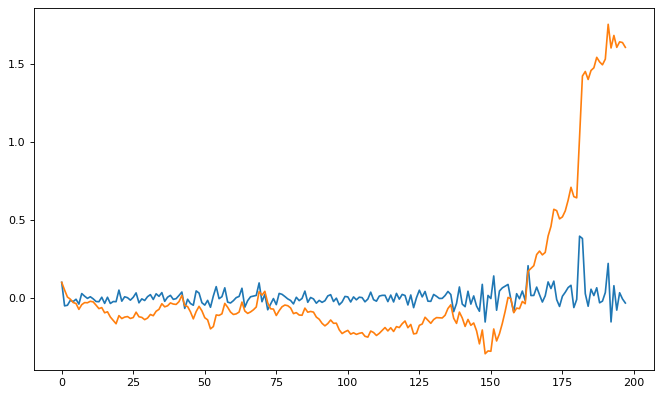

In [51]:
plt.figure(figsize=(10,6), dpi = 80)

cumulative = []
cumsum = 0
for i in plugInReturn:
    cumsum += i
    cumulative.append(cumsum)

plt.plot(plugInReturn)
plt.plot(cumulative)
#plt.plot(logRet['SPY'])


This is obviously so wildly outperforming the index so something is wrong with the code. My guess is that we get a massive jump in perfomance in what seems to be around the 2007 time period, and we have huge short positions in the portfolio that generate massive returns. Need to take a look at what's going wrong for the plug-in portfolio. 